# Generative Adversarial Networks

이안 굿펠로우님이 만드신 GAN입니다. 매우 유명하지만, 학습이 조금 많이 불안정한 네트워크죠. 이번에는 GAN을 구현해보려고 합니다.

In [ ]:
# 이 코드는 2번 GPU만 사용하기 위해 환경변수 "CUDA_VISIBLE_DEVICES"를 설정해준 것입니다.
# "CUDA_VISIBLE_DEVICES" 환경변수를 설정해 주게 되면 이 이후에 임포트된 cuda library에서는
# 해당 GPU 외에 GPU는 보이지 않게 됩니다.

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Library Import

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, losses, metrics, datasets
import numpy as np
import matplotlib.pyplot as plt

필요한 hyper parameter를 설정합니다. 하나의 데이터셋을 500번 돌 예정이며, batch size는 128로 할 것입니다.

In [3]:
EPOCHS = 500
BATCH_SIZE = 128

다음 코드는 MNIST 데이터셋을 불러옵니다. 이때, `trainset`, `testset`은 다음과 같은 모양이 됩니다.
```python
trainset = (x_train, y_train)
testset = (x_test, y_test)
```

In [4]:
trainset, testset = datasets.mnist.load_data()

이것을 tensorflow dataset `tf.data.Dataset` 객체로 만들어줄 것입니다. `trainset`, `testset`은 numpy객체이고, `tf.data.Dataset`은 `.from_tensor_slices`라는 메소드를 제공하여 numpy array를 `tf.data.Dataset`으로 변환하는 기능을 제공합니다.

`tf.data.Dataset.from_tensor_slices()`는 튜플을 입력으로 받는데, 튜플은 `(data_array, label_array)`의 형태이어야 합니다. `mnist.load_data()`메소드가 이미 그런 형태로 `trainset`, `testset`을 생성해 주었으므로, 그냥 그대로 `.from_tensor_slices`에 인자로 넘겨주면 됩니다.

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

여기서, `.batch(BATCH_SIZE).shuffle(4096)`라는 문구가 추가되었네요. 이것을 알기 이전에, `tf.data.Dataset`을 좀 더 알 필요가 있는데요, `tf.data.Dataset`은 python의 generator입니다.
즉, `iter()`로 감쌀 수 있고, `next()`함수로 어떤 원소를 generate할 수 있는 객체입니다. `tf.data.Dataset`은 `next()`를 한 번 호출할 때마다 데이터 샘플 1개를 기본적으로 반환합니다. 하지만, `.batch(BATCH_SIZE)`라는 메소드를 호출해주면, `next()`를 한 번 호출해 줄 때마다 `BATCH_SIZE`개 만큼의 데이터를 반환해줍니다.

`.shuffle(4096)`의 경우, 1번의 epoch을 돌때마다 `tf.data.Dataset`안의 데이터를 셔플해주라는 의미입니다. `4096`은 그냥 버퍼크기로, 셔플의 속도에 아주 조금 차이가 있는 것 같습니다.

## Implementation

In [6]:
class GenerativeAdversarialNetwork(models.Model):
    """
    Generative Adversarial Network class
    0~9까지의 숫자중 아무거나 하나 생성
    """
    
    def __init__(self):
        super(GenerativeAdversarialNetwork, self).__init__()
        
        # generator
        self.generator = models.Sequential([
            # 64 -> 256
            layers.Dense(256),
            layers.Activation(tf.nn.tanh),
            
            # 256 -> 256
            layers.Dense(256),
            layers.Activation(tf.nn.tanh),
            
            # 256 -> 784
            layers.Dense(784),
            layers.Activation(tf.nn.sigmoid),
        ])
        
        # discriminator
        self.discriminator = models.Sequential([
            # 784 -> 256
            layers.Dense(256),
            layers.Activation(tf.nn.tanh),
            layers.Dropout(0.5),
            
            # 256 -> 256
            layers.Dense(256),
            layers.Activation(tf.nn.tanh),
            layers.Dropout(0.5),
            
            # 256 -> 1
            layers.Dense(1),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x=None, training=False):
        """
        forward propagation.
        
        Arguments:
        ----------
        - x 2차원 텐서. 실제 이미지 배치 모양은 (BATCH_SIZE, 784)과 같음
        - training Boolean 값. forward propagation을 training 모드로 돌릴것인지, evaluation 모드로 돌릴 것인지
        
        Returns:
        --------
        - x_generated 2차원 텐서, 생성된 이미지. 모양은 (BATCH_SIZE, 784) 또는 None
        - d_real 1차원 벡터. 실제 이미지에 대해 discriminator가 판단한 것 (BATCH_SIZE, 1)
        - d_fake 1차원 벡터. 생성된 이미지에 대해 discriminator가 판단한 것 (BATCH_SIZE, 1)
        """
        
        # 배치사이즈 n을 얻어옵니다.
        if x is not None:
            n = tf.shape(x)[0]
        else:
            n = 1
        
        # 새로운 이미지를 생성하기 위한 노이즈를 생성합니다.
        noise = tf.random.normal(shape=(n, 64))
        
        # generate samples from noise
        x_generated = self.generator(noise, training=training)
        
        # 학습과정이라면, discriminator의 값도 반환해주고, evaluation과정이라면, 생성된 이미지만 반환합니다.
        if training is True:
            d_real = self.discriminator(x, training=training)
            d_fake = self.discriminator(x_generated, training=training)
            
            return x_generated, d_real, d_fake
        
        return x_generated

코드 분석을 해보면,

```python
# generator
self.generator = models.Sequential([
    # 64 -> 256
    layers.Dense(256),
    layers.Activation(tf.nn.tanh),

    # 256 -> 256
    layers.Dense(256),
    layers.Activation(tf.nn.tanh),

    # 256 -> 784
    layers.Dense(784),
    layers.Activation(tf.nn.sigmoid),
])
```

이 코드는 generator를 생성하는 코드입니다. generator는 3개층의 fully connected 로 구성되어 있습니다.

```python
# discriminator
self.discriminator = models.Sequential([
    # 784 -> 256
    layers.Dense(256),
    layers.Activation(tf.nn.tanh),
    layers.Dropout(0.5),

    # 256 -> 256
    layers.Dense(256),
    layers.Activation(tf.nn.tanh),
    layers.Dropout(0.5),

    # 256 -> 1
    layers.Dense(1),
    layers.Activation(tf.nn.sigmoid),
])
```

이 코드는 discriminator를 생성하는 코드입니다. 역시, 3개층의 fully connected layer로 구성되어 있습니다.

GAN은 임의의 저차원 noise신호로부터 이미지를 생성하게 됩니다. 다음 코드는 이미지를 생성하기 위한 노이즈를 생성하는 코드입니다.

```python
# 새로운 이미지를 생성하기 위한 노이즈를 생성합니다.
noise = tf.random.normal(shape=(n, 64))
```

이 노이즈 신호를 generator의 입력으로 넣습니다. generator는 이 노이즈 신호를 이용하여 새로운 이미지를 생성할 것입니다.

```python
# generate samples from noise
x_generated = self.generator(noise, training=training)
```

GAN의 핵심 역할은 이미지를 생성하는 것입니다. 하지만, 이미지를 생성할 수 있도록 GAN을 학습시켜야 합니다. GAN을 학습시키는 역할은 discriminator가 굉장히 중요한 역할을 차지합니다. 학습 과정에서는 generator가 생성한 이미지 뿐 아니라 discriminator의 결과또한 반환해 주어서, GAN loss를 만들 수 있도록 해 주어야 합니다.

```python
# 학습과정이라면, discriminator의 값도 반환해주고, evaluation과정이라면, 생성된 이미지만 반환합니다.
if training is True:
    d_real = self.discriminator(x, training=training)
    d_fake = self.discriminator(x_generated, training=training)

    return x_generated, d_real, d_fake

return x_generated
```

위 코드는 training 과정일때는 discriminator에 real image와 생성된 fake image를 둘 다 통과시켜서 얻은 discrminator 결과를 반환해주는 코드입니다. training 과정이 아니라면, 생성된 이미지만 반환해 줍니다.

## Training GAN

이제 구현한 GAN을 학습시키고 테스트해보겠습니다. 다음 코드는 GAN을 생성하고, 필요한 optimizer와 loss, 그리고 metric들을 선언해 주는 것입니다.

In [7]:
# GAN 객체 생성
gan = GenerativeAdversarialNetwork()

# generator의 optimizer와 discriminator의 optimizer를 따로 생성 (learning rate를 다르게 주기 위해)
# discriminator의 learning rate를 낮게 설정해 주었음
# discriminator의 학습이 보통 더 빠르기 때문에 이렇게 설정했음
optimizer_gen = optimizers.Adam(learning_rate=1e-3)
optimizer_dis = optimizers.RMSprop(learning_rate=1e-4)

# loss 함수
bce_criterion = losses.BinaryCrossentropy()

# metrics. loss를 축적하고 나중에 평균내주기 위함
gen_loss_obj = metrics.Mean()
dis_loss_obj = metrics.Mean()
dis_acc_obj = metrics.BinaryAccuracy()

In [8]:
def train_step(images):
    """
    1 batch에 대한 학습 과정을 구현한 함수
    
    Arguments:
    ----------
    - images: (batch_size, 784) 텐서. 이미지 데이터가 들어감
    """
    
    # 배치크기를 얻어옴
    n = tf.shape(images)[0]
    
    # loss 초기화
    loss_gen = 0.0
    loss_dis = 0.0
    
    # gradient 계산을 위해 gradient tape을 활성화
    # persistent = True에 주목!
    with tf.GradientTape(persistent=True) as tape:
        # forward propagation
        images = tf.reshape(images, shape=(n, -1))
        x_generated, d_real, d_generated = gan(images, training=True)

        # generator loss
        loss_gen += bce_criterion(tf.ones((n,)), d_generated)

        # discriminator loss
        loss_dis += bce_criterion(tf.ones((n,)), d_real)
        loss_dis += bce_criterion(tf.zeros((n,)), d_generated)

    # Generator의 gradient 계산
    grads_gen = tape.gradient(loss_gen, gan.generator.trainable_variables)
    # Generator weights 업데이트
    optimizer_gen.apply_gradients(zip(grads_gen, gan.generator.trainable_variables))

    # 나중에 print를 위해 generator loss를 gen_loss_obj 객체에 축적함
    gen_loss_obj.update_state(loss_gen)
        
    # discriminator의 gradient 계산, 이때, tf.GradientTape에 persistent=True가 없으면 에러남(아래 설명 참고)
    grads_dis = tape.gradient(loss_dis, gan.discriminator.trainable_variables)
    # discriminator weights 업데이트
    optimizer_dis.apply_gradients(zip(grads_dis, gan.discriminator.trainable_variables))

    # 나중에 print를 위해 discriminator loss를 dis_loss_obj 객체에 축적함
    dis_loss_obj.update_state(loss_dis)

    # 나중에 print를 위해 accuray도 계산해서 축적해 놓음
    dis_acc_obj.update_state(tf.ones((n,)), d_real)
    dis_acc_obj.update_state(tf.zeros((n,)), d_generated)

한 가지 특이한 점이 보이네요. `tf.GradientTape()`객체를 만들어줄때, `persistent=True`라는 옵션을 주었습니다. 일반적으로 `tf.GradientTape`객체는 `tape.gradient`를 한 번 호출하게되면 gradient를 계산해주고 partial derivative를 모두 초기화시켜버립니다. 그래서 다시 `tape.gradient`를 호출하게 되면 계산된 gradient가 없다고 에러를 뱉게 됩니다. 이를 막기 위해, `tape.gradient`를 호출하더라도 계산해놓은 partial derivitive를 파기하기 않도록 해야 하는데, `persistent=True`가 그런 역할을 담당합니다. 즉, partial derivitive를 영원히 갖고 있으라는 옵션입니다. 

보시면, `tf.GradientTape()`을 만든 후, 아래쪽에서 같은 `tape`에 대해 두 번의 `tape.gradient`를 호출하고 있습니다.

```python
...
grads_gen = tape.gradient(loss_gen, gan.generator.trainable_variables)
...
grads_dis = tape.gradient(loss_dis, gan.discriminator.trainable_variables)
...
```

만약, `persistent=True`가 없었으면, 두 번째 `tape.gradient` 호출에서 에러가 날 것입니다. 이미 partial derivitive를 첫 번째 `tape.gradient` 호출 이후 파기하기 때문이죠.

이제 학습 코드를 뜯어보겠습니다.

```python
with tf.GradientTape(persistent=True) as tape:
    images = tf.reshape(images, shape=(n, -1))
    x_generated, d_real, d_generated = gan(images, training=True)

    # generator loss of gan
    loss_gen += bce_criterion(tf.ones((n,)), d_generated)

    loss_dis += bce_criterion(tf.ones((n,)), d_real)
    loss_dis += bce_criterion(tf.zeros((n,)), d_generated)
```

이 코드를 보면, 일단, gan()을 호출하면서 forward propagation을 합니다. `training=True`로 두어 discriminator의 값도 반환하게 합니다.
그리고 나서, `loss_gen`(generator loss)에 generator loss를 계산해서 더해주는데요, 이때, generator loss는 다음처럼 계산됩니다.

```python
loss_gen += bce_criterion(tf.ones((n,)), d_generated)
```

d_generated는 discriminator의 아웃풋으로, sigmoid 값입니다. Discrminator의 아웃풋은 하나의 이미지에 대해 0 아니면 1인데, 이미지가 가짜라고 판단하면 0, 진짜라고 판단하면 1이라고 예측하게 해야 합니다. Discriminator는 생성된 이미지는 0이라고 예측(가짜라고 예측)하게 해야 하며, 진짜 이미지는 1이라고 예측하게 해야 합니다. 그렇게 해서 discriminator는 진짜 이미지와 가짜 이미지를 구별할 수 있도록 학습하고, generator에게 진짜 이미지를 생성할 수 있도록 피드백을 주어야 합니다.

위 식에서의 generator loss가 discriminator로부터 피드백을 받는 loss인데요, discriminator가 1이라고 판단되게끔 **generator의 weight를 업데이트** 해 주기 위한 loss입니다.

다음은 discriminator의 loss입니다.

```python
loss_dis += bce_criterion(tf.ones((n,)), d_real)
loss_dis += bce_criterion(tf.zeros((n,)), d_generated)
```

Discriminator의 임무는 가짜와 진짜를 잘 맞추도록 학습해서 generator에게 좋은 피드백을 주는 것입니다. 그러기 위해서는 가짜와 진짜를 잘 맞춰야 합니다. 위 loss가 그런 loss입니다. d_real, 즉, 진짜에 대한 예측은 1로, d_generated, 가짜에 대한 예측은 0으로 학습하도록 하는 binary cross entropy입니다.

다음은 테스트 함수와 학습 함수를 구현한 것입니다.

In [9]:
def test():
    """
    이미지가 잘 생성되었는지 이미지를 플롯해주는 함수
    """
    
    # 이미지를 플롯할 도화지의 크기를 정해주는 과정이라고 보시면 됩니다.
    # figsize=(10, 2), 가로가 10, 세로가 2인 도화지를 세팅하는 것입니다.
    plt.figure(figsize=(10, 2), dpi=80)
    
    # 이미지를 5개 생성해서 시각화할 것입니다.
    for i in range(5):
        # 이미지 생성 (training=False)
        generated = gan(None, training=False)
        generated = tf.reshape(generated, shape=(28, 28))
        
        # tensorflow tensor를 넘파이 배열로 바꿔줌
        img = generated.numpy().squeeze()
        
        # 이미지를 가로로 5장, 세로로 1장씩 출력할 것입니다.
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
        
    plt.show()

In [10]:
def train():
    """
    학습 함수
    """
    
    # 데이터셋을 EPOCHS 만큼 학습
    for e in range(EPOCHS):
        for x, y in trainloader: # tf.data.Dataset이 generator라서 이렇게 할 수 있음
            x_batch = tf.cast(x, dtype=tf.float32)/256
            x_batch = tf.expand_dims(x_batch, axis=-1)
            train_step(x_batch)
            
        # 한 번의 epoch이 끝나면 축적해놓은 loss, accuracy를 모두 불러옴
        gen_loss = gen_loss_obj.result()
        dis_loss = dis_loss_obj.result()
        dis_acc = dis_acc_obj.result()
        
        # 그리고 다음 epoch에서 다시 축적하기 위해 기존값을 초기화
        gen_loss_obj.reset_states()
        dis_loss_obj.reset_states()
        dis_acc_obj.reset_states()

        if e == 0 or (e+1)%100 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, generator loss: {gen_loss:.8f}, discriminator loss: {dis_loss:.8f}, discriminator acc: {dis_acc:.4f}")
            test()

여기서, 다음 구문을 봅시다.

```python
for x, y in trainloader: # tf.data.Dataset이 generator라서 이렇게 할 수 있음
    x_batch = tf.cast(x, dtype=tf.float32)/256
    x_batch = tf.expand_dims(x_batch, axis=-1)
    train_step(x_batch)
```

이때, `for`문을 보시면, trainloader (`tf.data.Dataset` 객체)를 바로 `for`문에 이용하고 있는데요, `tf.data.Dataset`객체는 generator라고 했습니다.
Generator 객체는 `for`문을 돌 수 있습니다. 이때, 저희는 `batch(BATCH_SIZE)`로 배치 크기를 정해주었으므로, 1번의 iteration으로 `BATCH_SIZE`개의 이미지와 라벨이 각각 `x`, `y`에 할당되게 됩니다.

학습해보죠!

Epochs 1/500, generator loss: 4.74126673, discriminator loss: 0.26119840, discriminator acc: 0.9605


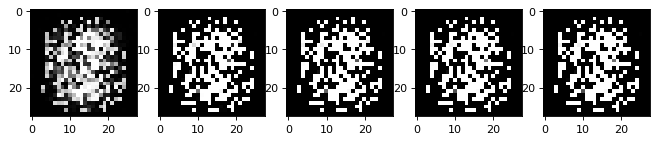

Epochs 100/500, generator loss: 0.86514151, discriminator loss: 1.26894677, discriminator acc: 0.6370


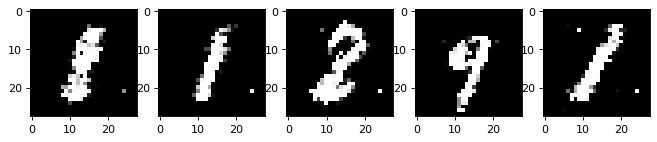

Epochs 200/500, generator loss: 0.82000428, discriminator loss: 1.31544971, discriminator acc: 0.6058


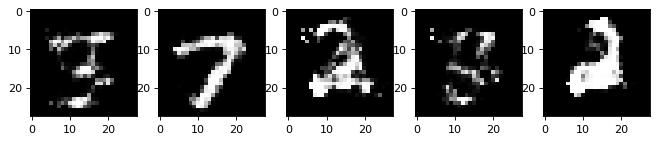

Epochs 300/500, generator loss: 0.86463040, discriminator loss: 1.28024256, discriminator acc: 0.6274


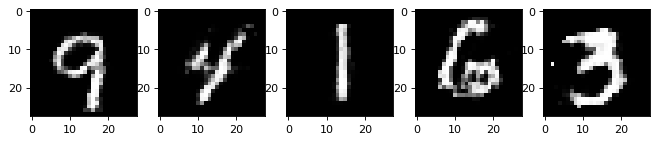

Epochs 400/500, generator loss: 0.85196918, discriminator loss: 1.28656483, discriminator acc: 0.6246


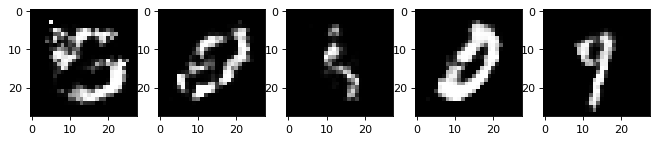

Epochs 500/500, generator loss: 0.83383715, discriminator loss: 1.30287695, discriminator acc: 0.6134


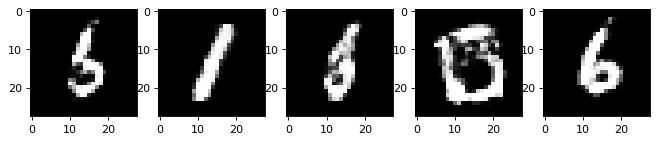

In [11]:
train()

GAN을 학습해보았는데요, 그런데, 막상 직접 똑같은 코드를 돌리신다고 해도 이렇게 생성이 안 될 가능성이 높습니다. GAN 학습 자체가 많이 불안정합니다. 그래서 될때 있고 안될때가 있고, 이런게 너무 심합니다. 그래서 DCGAN이나, WGAN과 같이 GAN의 학습을 좀 안정화시키려는 노력이 많이 있었습니다. DCGAN과 WGAN은 곧 다룰 예정입니다.

감사합니다.